## Setup

In [3]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig

In [4]:
print("This notebook was created using version 1.22.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.22.0 of the Azure ML SDK
You are currently using version 1.22.0 of the Azure ML SDK


In [5]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-gsk-forecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,08d28dbf-1252-4438-b3be-0188e3803935
Workspace,Forecasting
SKU,Basic
Resource Group,forecastrg
Location,westcentralus
Run History Name,automl-gsk-forecasting


In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [7]:

data = pd.read_csv("5_products.csv", sep=";")#, parse_dates=[time_column_name])
data.head()

,SalesOrg,Customer_Name,EAN_UPC_Code,Week_Date_Start,Currency,Sales_Value,Sales_Volume,Retail Sales Price,Base_Sales_Value,Base_Sales_Volume,...,ACV Weighted Distribution Feature Only,ACV Weighted Distribution Display Only,ACV Weighted Distribution Feature and Display,ACV Weighted Distribution Feature and/or Display,RoS,Promoted ACV %,In-store Price Discount %,COVID,Week_of_Year,Post event deep
0,B01,B,33409,2019-01-06,BBB,156797.7504,15663.83795,10.010174,151826.9869,15124.09927,...,0.00000,7.514310,0.000000,7.514310,195.833734,0.114147,0.997154,0.0,1,0
1,B01,B,33409,2019-01-13,BBB,186126.9462,21054.32601,8.840318,127852.6208,13004.89625,...,71.97082,0.289375,6.977614,79.237809,257.859076,0.986674,0.899218,0.0,2,0
2,B01,B,33409,2019-01-20,BBB,137389.4442,13726.81460,10.008837,134915.7095,13467.75593,...,0.00000,4.671196,0.000000,4.671196,182.537430,0.082453,0.999117,0.0,3,0
3,B01,B,33409,2019-01-27,BBB,152807.1377,16650.00195,9.177605,115114.5846,11889.90972,...,72.92160,0.033262,4.845493,77.800355,206.959266,0.967057,0.947933,0.0,4,0
4,B01,B,33409,2019-02-03,BBB,136449.5288,13632.72777,10.008967,133447.8132,13295.02824,...,0.00000,4.910082,0.000000,4.910082,180.106254,0.086928,0.997165,0.0,5,0


In [8]:
time_column_name = 'Week_Date_Start'
# Drop the columns 'logQuantity' as it is a leaky feature.


In [9]:
#data.drop('logQuantity', axis=1, inplace=True)
data = data[['EAN_UPC_Code','Retail Sales Price','ACV Weighted Distribution','Week_Date_Start']].copy()
data.head()

,EAN_UPC_Code,Retail Sales Price,ACV Weighted Distribution,Week_Date_Start
0,33409,10.010174,79.985392,2019-01-06
1,33409,8.840318,81.650514,2019-01-13
2,33409,10.008837,75.199999,2019-01-20
3,33409,9.177605,80.450623,2019-01-27
4,33409,10.008967,75.692695,2019-02-03


In [11]:
nseries = time_series_id_column_names = ['EAN_UPC_Code']
nseries = data.groupby(time_series_id_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))

Data contains 5 individual time-series.


#### Load Scoring file into Forecast dataframe

In [12]:
forecast = pd.read_csv("SCORING_5_products.csv", sep=";")#, parse_dates=[time_column_name])
forecast.head()

,EAN_UPC_Code,Week_Date_Start,Retail Sales Price,ACV Weighted Distribution
0,33409,2020-06-21,10.018474,69.381296
1,33409,2020-06-28,10.009992,70.695163
2,33409,2020-07-05,10.010965,72.442687
3,33409,2020-07-12,10.009826,74.092185
4,33409,2020-07-19,10.017034,71.756207


### Data Splitting
##### This is not strictly needed


In [14]:
n_test_periods = 4

def split_last_n_by_series_id(df, n):
    """Group df by series identifiers and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name) # Sort by ascending time
                  .groupby(time_series_id_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail

train, test = split_last_n_by_series_id(data, n_test_periods)

### Upload data to datastore


In [15]:
train.to_csv (r'./gsk_train.csv', index = None, header=True)
test.to_csv (r'./gsk_test.csv', index = None, header=True)
#fct.to_csv (r'./gsk_forecast.csv', index = None, header=True)

In [16]:
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./gsk_train.csv', './gsk_test.csv'], target_path = 'dataset/', overwrite = True,show_progress = True)

Uploading an estimated of 2 files
Uploading ./gsk_train.csv
Uploaded ./gsk_train.csv, 1 files out of an estimated total of 2
Uploading ./gsk_test.csv
Uploaded ./gsk_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_0c1651cfab6c4aab8cd0ceca2ae1fb48

### Create dataset for training

In [18]:
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('dataset/gsk_train.csv'))

In [19]:
train_dataset.to_pandas_dataframe().tail()

,EAN_UPC_Code,Retail Sales Price,ACV Weighted Distribution,Week_Date_Start
355,41753,7.212368,38.587146,2020-04-19
356,41753,6.998095,41.524821,2020-04-26
357,41753,7.749710,38.024747,2020-05-03
358,41753,6.594763,49.920869,2020-05-10
359,41753,7.728895,40.487587,2020-05-17


## Modeling



In [21]:
target_column_name = 'ACV Weighted Distribution'

## Train


In [22]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=n_test_periods,
    time_series_id_column_names=time_series_id_column_names
)

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_gsk_sales_errors.log',
                             primary_metric='normalized_mean_absolute_error',
                             experiment_timeout_hours=0.25,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             featurization='auto',
                             n_cross_validations=3,
                             verbosity=logging.INFO,
                             max_cores_per_iteration=-1,
                             forecasting_parameters=forecasting_parameters)

In [23]:
remote_run = experiment.submit(automl_config, show_output=False)
remote_run

Running on remote.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-gsk-forecasting,AutoML_5b3e8c85-e09a-4b44-a5fa-5944d06f35ed,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [24]:
remote_run.wait_for_completion()

{'runId': 'AutoML_5b3e8c85-e09a-4b44-a5fa-5944d06f35ed',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-04-18T22:01:56.080879Z',
 'endTimeUtc': '2021-04-18T22:28:14.459079Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-gsk-forecasting","subscription_id":"08d28dbf-1252-4438-b3be-0188e3803935","resource_group":"forecastrg","workspace_name":"Forecasting","region":"westcentralus","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"normalized_mean_absolute_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validations":3,"y_min":null,"y_max":n

### Retrieve the Best Model


In [25]:
best_run, fitted_model = remote_run.get_output()
print(fitted_model.steps)
model_name = best_run.properties['model_name']

Package:azureml-automl-runtime, training version:1.26.0, current version:1.22.0
Package:azureml-core, training version:1.26.0, current version:1.22.0
Package:azureml-dataprep, training version:2.13.2, current version:2.9.1
Package:azureml-dataprep-native, training version:32.0.0, current version:29.0.0
Package:azureml-dataprep-rslex, training version:1.11.2, current version:1.7.0
Package:azureml-dataset-runtime, training version:1.26.0, current version:1.22.0
Package:azureml-defaults, training version:1.26.0, current version:1.22.0
Package:azureml-interpret, training version:1.26.0, current version:1.22.0
Package:azureml-mlflow, training version:1.26.0, current version:1.20.0.post1
Package:azureml-pipeline-core, training version:1.26.0, current version:1.22.0
Package:azureml-telemetry, training version:1.26.0, current version:1.22.0
Package:azureml-train-automl-client, training version:1.26.0, current version:1.22.0
Package:azureml-train-automl-runtime, training version:1.26.0, current

[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
                      pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('ProphetModel', <azureml.automl.runtime.shared._prophet_model.ProphetModel object at 0x7f46eb6a8048>)]


# Validation
##### This is not strictly needed


In [26]:
X_test = test
y_test = X_test.pop(target_column_name).values

In [27]:
X_test.head()

,EAN_UPC_Code,Retail Sales Price,Week_Date_Start
72,33409,10.02,2020-05-24
73,33409,10.01,2020-05-31
74,33409,10.01,2020-06-07
75,33409,10.01,2020-06-14
148,34462,28.91,2020-05-24


In [28]:
y_predictions, X_trans = fitted_model.forecast(X_test)

# FORECAST

In [29]:
forecast.head()

,EAN_UPC_Code,Week_Date_Start,Retail Sales Price,ACV Weighted Distribution
0,33409,2020-06-21,10.02,69.38
1,33409,2020-06-28,10.01,70.70
2,33409,2020-07-05,10.01,72.44
3,33409,2020-07-12,10.01,74.09
4,33409,2020-07-19,10.02,71.76


In [30]:
X_fct=forecast.copy() #Take a copy of the Scoring data
y_fct = X_fct.pop(target_column_name).values

In [31]:
X_fct.head()

,EAN_UPC_Code,Week_Date_Start,Retail Sales Price
0,33409,2020-06-21,10.02
1,33409,2020-06-28,10.01
2,33409,2020-07-05,10.01
3,33409,2020-07-12,10.01
4,33409,2020-07-19,10.02


In [32]:
y_predictions, X_trans = fitted_model.forecast(X_fct)# predict values using best model

In [33]:
forecast['Forecast'] = y_predictions # add predictions to the Forecast Dataframe

In [34]:
forecast.loc[forecast['EAN_UPC_Code']==33409] # select one product to visualize the forecast

,EAN_UPC_Code,Week_Date_Start,Retail Sales Price,ACV Weighted Distribution,Forecast
0,33409,2020-06-21,10.02,69.38,66.62
1,33409,2020-06-28,10.01,70.70,66.23
2,33409,2020-07-05,10.01,72.44,66.96
3,33409,2020-07-12,10.01,74.09,66.52
4,33409,2020-07-19,10.02,71.76,66.04
5,33409,2020-07-26,10.01,71.34,65.63
6,33409,2020-08-02,10.02,71.16,66.23


# Evaluate Forecast

In [35]:
assign_dict = {'Forecast': y_predictions, target_column_name: forecast['Retail Sales Price']}
df_all = forecast.assign(**assign_dict)

[Test data scores]

normalized_median_absolute_error:   1.000
normalized_mean_absolute_error:   1.000
root_mean_squared_log_error:   1.383
root_mean_squared_error:   36.995
mean_absolute_error:   34.131
normalized_root_mean_squared_error:   1.000
r2_score:   -1.000
spearman_correlation:   0.010
explained_variance:   -1.060
median_absolute_error:   35.823
normalized_root_mean_squared_log_error:   0.998
mean_absolute_percentage_error:   342.879


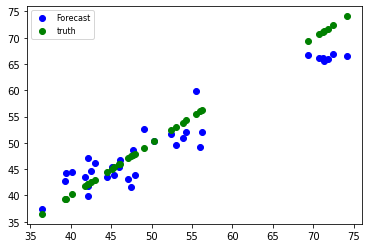

In [36]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=forecast['Retail Sales Price'],
    y_pred=forecast['Forecast'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(forecast[target_column_name], forecast['Forecast'], color='b')
test_test = plt.scatter(forecast[target_column_name], forecast[target_column_name], color='g')
plt.legend((test_pred, test_test), ('Forecast', 'truth'), loc='upper left', fontsize=8)
plt.show()